In [37]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import sys
class Reliability:
    class ra_cap_dem:
        def __init__(self, demand, capacity, alpha=None):
            self.demand_x = demand["x"]
            self.demand_y = demand["y"]

            self.capacity_x = capacity["x"]
            self.capacity_y = capacity["y"]

            self.alpha = alpha
            
        def find_intersection(self, alpha):
            substract_demand_x = self.demand_x[1:] - self.demand_x[:-1]
            demand_x_diff_mean = np.mean(substract_demand_x)

            substract_demand_y = self.demand_y[1:] - self.demand_y[:-1]
            demand_y_diff_mean = np.mean(substract_demand_y)

            substract_capacity_x = self.capacity_x[1:] - self.capacity_x[:-1]
            capacity_x_diff_mean = np.mean(substract_capacity_x)

            substract_capacity_y = self.capacity_y[1:] - self.capacity_y[:-1]
            capacity_y_diff_mean = np.mean(substract_capacity_y)
            close_values = []
            self.x_close_values = []
            for demand_index,value in enumerate(self.demand_x):
                for capacity_index ,to_sub in enumerate(self.capacity_x):
                    if abs(value - to_sub) <= alpha :
                        self.x_close_values.append((demand_index, capacity_index))
                        if abs(self.demand_y[demand_index] - self.capacity_y[capacity_index]) <= alpha:
                            close_values.append((demand_index, capacity_index, abs(self.demand_y[demand_index] - self.capacity_y[capacity_index])))
                        break
            self.minimum_variable = min(close_values, key=lambda t:t[2])
            return self.minimum_variable

        def set_under_curve(self):
            self.find_intersection(self.alpha)
            self.under_curve_x = []
            self.under_curve_y = []
            for value in self.x_close_values:
                self.under_curve_x.append(self.demand_x[value[0]])
                self.under_curve_y.append(min(self.demand_y[value[0]],self.capacity_y[value[1]]))
            self.under_curve_x = np.array(self.under_curve_x)
            self.under_curve_y = np.array(self.under_curve_y)
            return {"x_under":self.under_curve_x, "y_under":self.under_curve_y}
            

        def get_area_under_curve(self):
            self.set_under_curve()
            delta_x = np.array(self.under_curve_x[1:]-self.under_curve_x[:-1])
            return np.sum(delta_x*self.under_curve_y[:-1])

        def add_color_under_curve(self, color="yellow"):
            self.get_area_under_curve()
            plt.fill(self.under_curve_x, self.under_curve_y, color=color)
            
        def plot(self):
            plt.plot(self.demand_x, self.demand_y, color="blue")
            plt.plot(self.capacity_x, self.capacity_y, color="red")
            plt.xlabel("$x$",fontsize=15)
            plt.ylabel("$PDF$",fontsize=15)
            
    class ra_dem:
        def __init__(self, demand, capacity):
            self.demand_x = demand["x"]
            self.demand_y = demand["y"]
            self.capacity = capacity
        
        def set_under_curve(self):
            self.under_curve_x = []
            self.under_curve_y = []
            for index,value in enumerate(self.demand_x):
                if value > self.capacity:
                    self.under_curve_x.append(value)
                    self.under_curve_y.append(self.demand_y[index])
            self.under_curve_x = np.array(self.under_curve_x)
            self.under_curve_y = np.array(self.under_curve_y)
            return {"x_under":self.under_curve_x, "y_under":self.under_curve_y}

        def get_area_under_curve(self):
            self.set_under_curve()
            delta_x = np.array(self.under_curve_x[1:]-self.under_curve_x[:-1])
            return np.sum(delta_x*self.under_curve_y[:-1])
        
        def plot(self):
            plt.axvline(x=self.capacity, color="red")
            plt.plot(self.demand_x, self.demand_y, color="blue")

        def add_color_under_curve(self, color="yellow"):
            self.get_area_under_curve()
            plt.fill_between(self.under_curve_x, 0, self.under_curve_y, color=color)

    class ra_cap:
        def __init__(self, demand, capacity):
            self.capacity_x = capacity["x"]
            self.capacity_y = capacity["y"]
            self.demand = demand
        
        def set_under_curve(self):
            self.under_curve_x = []
            self.under_curve_y = []
            for index,value in enumerate(self.capacity_x):
                if value < self.demand:
                    self.under_curve_x.append(value)
                    self.under_curve_y.append(self.capacity_y[index])

            self.under_curve_x = np.array(self.under_curve_x)
            self.under_curve_y = np.array(self.under_curve_y)
            return {"x_under":self.under_curve_x, "y_under":self.under_curve_y}

        def get_area_under_curve(self):
            self.set_under_curve()
            delta_x = np.array(self.under_curve_x[1:]-self.under_curve_x[:-1])
            return np.sum(delta_x*self.under_curve_y[:-1])
        
        def plot(self):
            plt.axvline(x=self.demand, color="red")
            plt.plot(self.capacity_x, self.capacity_y, color="blue")

        def add_color_under_curve(self, color="yellow"):
            self.get_area_under_curve()
            plt.fill_between(self.under_curve_x, 0, self.under_curve_y, color=color)
    class SafetyIndex:
        def __init__(self, mu_load, sigma_load,
        v_load=0.3, v_resist=0.2, k_load=0.95, k_resist=0.9, P_target=10**(-5), lower_than=0.01 ):
            self.diff = None
            self.init_fract = 1.4
            self.to_add = 0.1
            self.mu_load = mu_load
            self.norm_inv_p_target = stats.norm.ppf(P_target)
            i = 1
            while self.diff == None or self.diff > lower_than:
                i += 1
                self.init_fract += self.to_add
                self.mu_resist = self.init_fract * self.mu_load * (1 + k_load * v_load)/(1 - k_resist * v_resist)
                self.sigma_resist = v_resist * self.mu_resist
                self.beta = (self.mu_resist - self.mu_load)/((sigma_load**2 + self.sigma_resist**2)**0.5)
                if self.beta + self.norm_inv_p_target < 0 :
                    self.to_add = abs(self.to_add)
                else:
                    self.to_add *= (-1/2)
                self.diff = abs(self.beta - abs(self.norm_inv_p_target))

        def get_beta(self):
            return self.beta

        def get_diff(self):
            return self.diff

        def get_mu_resist(self):
            return self.mu_resist
        
        def get_sigma_resits(self):
            return self.sigma_resist

        def get_fract(self):
            return self.init_fract


0.12768837719369155


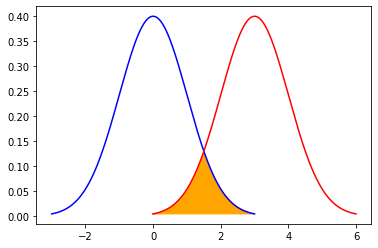

0.4986367531478954


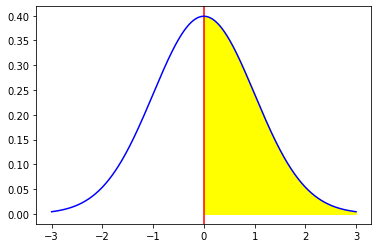

0.49626733192773087


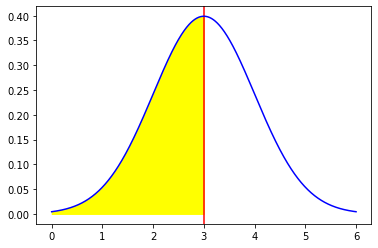

In [25]:

# Demand
mu = 0
variance = 1
sigma = math.sqrt(variance)
x1 = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y1 = stats.norm.pdf(x1, mu, sigma)

# Capacity
mu = 3
variance = 1
sigma = math.sqrt(variance)
x2 = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y2 = stats.norm.pdf(x2, mu, sigma)

#define Capacity and deman
demand = {"x":x1 ,"y":y1}
capacity = {"x":x2, "y":y2}

# initialize Random Capacity and Demand
ra_cap_dem = Reliability.ra_cap_dem(demand,capacity, 0.0303033)
ra_cap_dem.add_color_under_curve("orange")
ra_cap_dem.plot()
print(ra_cap_dem.get_area_under_curve())
plt.show()

# initialize Random Demand
ra_demand = Reliability.ra_dem(demand,0)
print(ra_demand.get_area_under_curve())
ra_demand.plot()
ra_demand.add_color_under_curve()
plt.show()
# initialize Random Capacity
ra_capacity = Reliability.ra_cap(3,capacity)
print(ra_capacity.get_area_under_curve())
ra_capacity.plot()
ra_capacity.add_color_under_curve()

In [54]:
safetyIndex = Reliability.SafetyIndex(50, 15, lower_than=0.001)
safetyIndex.get_mu_resist()

381.97408536585357